# FIA & RILA Pricing Demo

This notebook demonstrates the actuarial pricing framework for:
- **FIA (Fixed Indexed Annuity)**: Index-linked returns with 0% floor
- **RILA (Registered Index-Linked Annuity)**: Partial downside protection via buffer/floor

**Key Concepts**:
1. FIA = Bond + Embedded Call Option
2. RILA Buffer = Put Spread (absorbs FIRST X% of losses)
3. RILA Floor = OTM Put (limits MAX loss to X%)

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Annuity pricing imports
from annuity_pricing.data.schemas import FIAProduct, RILAProduct, MYGAProduct
from annuity_pricing.products.registry import (
    ProductRegistry,
    MarketEnvironment,
    create_default_registry,
)
from annuity_pricing.validation import validate_pricing_result, ensure_valid

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.precision', 4)

## 1. Market Environment Setup

Define market conditions for pricing:

In [2]:
# Create market environment
market = MarketEnvironment(
    risk_free_rate=0.05,      # 5% risk-free rate
    spot=100.0,               # Index level (normalized)
    dividend_yield=0.02,      # 2% dividend yield
    volatility=0.20,          # 20% annual volatility
    option_budget_pct=0.03,   # 3% option budget for FIA
)

# Create registry with reproducible results
registry = ProductRegistry(
    market_env=market,
    n_mc_paths=100000,
    seed=42,
)

print("Market Environment:")
print(f"  Risk-free rate: {market.risk_free_rate:.1%}")
print(f"  Volatility: {market.volatility:.1%}")
print(f"  Option budget: {market.option_budget_pct:.1%}")

Market Environment:
  Risk-free rate: 5.0%
  Volatility: 20.0%
  Option budget: 3.0%


## 2. FIA Pricing

### 2.1 Single FIA Product

Price a FIA with 10% cap:

In [3]:
# Create FIA product with cap
fia_cap = FIAProduct(
    company_name="Example Life",
    product_name="S&P 500 10% Cap",
    product_group="FIA",
    status="current",
    cap_rate=0.10,
    index_used="S&P 500",
)

# Price it
fia_result = registry.price(fia_cap, term_years=1.0, premium=100.0)

print("FIA Pricing Result:")
print(f"  Present Value: ${fia_result.present_value:.2f}")
print(f"  Embedded Option Value: ${fia_result.embedded_option_value:.4f}")
print(f"  Option Budget: ${fia_result.option_budget:.4f}")
print(f"  Expected Credit: {fia_result.expected_credit:.2%}")
print(f"  Fair Cap (given budget): {fia_result.fair_cap:.2%}")
print(f"  Fair Participation: {fia_result.fair_participation:.2%}")

FIA Pricing Result:
  Present Value: $99.16
  Embedded Option Value: $4.0384
  Option Budget: $3.0000
  Expected Credit: 4.24%
  Fair Cap (given budget): 6.97%
  Fair Participation: 32.51%


### 2.2 Compare Cap vs Participation

Create products with different crediting methods:

In [4]:
# Cap-based product
fia_cap = FIAProduct(
    company_name="Example Life",
    product_name="10% Cap",
    product_group="FIA",
    status="current",
    cap_rate=0.10,
)

# Participation-based product
fia_par = FIAProduct(
    company_name="Example Life",
    product_name="50% Participation",
    product_group="FIA",
    status="current",
    participation_rate=0.50,
)

# Price both
cap_result = registry.price(fia_cap, term_years=1.0)
par_result = registry.price(fia_par, term_years=1.0)

comparison = pd.DataFrame({
    'Metric': ['Expected Credit', 'Embedded Option Value', 'Present Value'],
    '10% Cap': [f"{cap_result.expected_credit:.2%}", 
                f"${cap_result.embedded_option_value:.4f}", 
                f"${cap_result.present_value:.2f}"],
    '50% Participation': [f"{par_result.expected_credit:.2%}", 
                          f"${par_result.embedded_option_value:.4f}", 
                          f"${par_result.present_value:.2f}"],
})

print("\nCap vs Participation Comparison:")
display(comparison)


Cap vs Participation Comparison:


,Metric,10% Cap,50% Participation
0,Expected Credit,4.24%,4.86%
1,Embedded Option Value,$4.0384,$4.6135
2,Present Value,$99.16,$99.74


### 2.3 Cap Rate Sensitivity

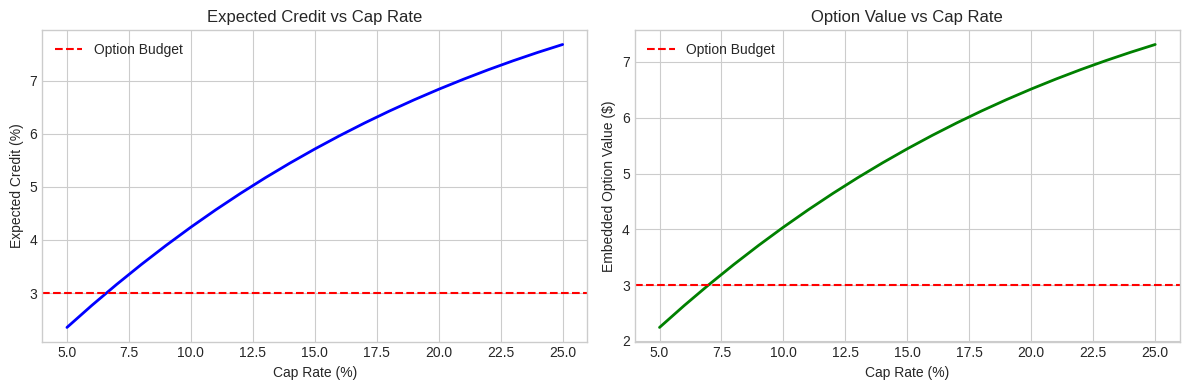

In [5]:
# Analyze sensitivity to cap rate
cap_rates = np.arange(0.05, 0.26, 0.01)
expected_credits = []
option_values = []

for cap in cap_rates:
    product = FIAProduct(
        company_name="Test", product_name=f"{cap:.0%} Cap",
        product_group="FIA", status="current", cap_rate=cap,
    )
    result = registry.price(product, term_years=1.0)
    expected_credits.append(result.expected_credit)
    option_values.append(result.embedded_option_value)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(cap_rates * 100, np.array(expected_credits) * 100, 'b-', linewidth=2)
ax1.axhline(y=market.option_budget_pct * 100, color='r', linestyle='--', label='Option Budget')
ax1.set_xlabel('Cap Rate (%)')
ax1.set_ylabel('Expected Credit (%)')
ax1.set_title('Expected Credit vs Cap Rate')
ax1.legend()

ax2.plot(cap_rates * 100, option_values, 'g-', linewidth=2)
ax2.axhline(y=market.option_budget_pct * 100, color='r', linestyle='--', label='Option Budget')
ax2.set_xlabel('Cap Rate (%)')
ax2.set_ylabel('Embedded Option Value ($)')
ax2.set_title('Option Value vs Cap Rate')
ax2.legend()

plt.tight_layout()
plt.show()

## 3. RILA Pricing

### 3.1 Buffer Protection

**Buffer**: Insurer absorbs the FIRST X% of losses.

In [6]:
# Create RILA with 10% buffer
rila_buffer = RILAProduct(
    company_name="Example Life",
    product_name="10% Buffer S&P 500",
    product_group="RILA",
    status="current",
    buffer_rate=0.10,
    buffer_modifier="Losses Covered Up To",  # Buffer
    cap_rate=0.15,
    index_used="S&P 500",
)

buffer_result = registry.price(rila_buffer, term_years=1.0, premium=100.0)

print("RILA Buffer Pricing Result:")
print(f"  Present Value: ${buffer_result.present_value:.2f}")
print(f"  Protection Type: {buffer_result.protection_type}")
print(f"  Protection Value: ${buffer_result.protection_value:.4f}")
print(f"  Upside Value: ${buffer_result.upside_value:.4f}")
print(f"  Expected Return: {buffer_result.expected_return:.2%}")
print(f"  Max Loss: {buffer_result.max_loss:.1%}")

RILA Buffer Pricing Result:
  Present Value: $97.83
  Protection Type: buffer
  Protection Value: $3.6156
  Upside Value: $5.4438
  Expected Return: 2.85%
  Max Loss: 90.0%


### 3.2 Floor Protection

**Floor**: Limits the MAXIMUM loss to X%.

In [7]:
# Create RILA with 10% floor
rila_floor = RILAProduct(
    company_name="Example Life",
    product_name="10% Floor S&P 500",
    product_group="RILA",
    status="current",
    buffer_rate=0.10,
    buffer_modifier="Losses Covered After",  # Floor
    cap_rate=0.15,
    index_used="S&P 500",
)

floor_result = registry.price(rila_floor, term_years=1.0, premium=100.0)

print("RILA Floor Pricing Result:")
print(f"  Present Value: ${floor_result.present_value:.2f}")
print(f"  Protection Type: {floor_result.protection_type}")
print(f"  Protection Value: ${floor_result.protection_value:.4f}")
print(f"  Upside Value: ${floor_result.upside_value:.4f}")
print(f"  Expected Return: {floor_result.expected_return:.2%}")
print(f"  Max Loss: {floor_result.max_loss:.1%}")

RILA Floor Pricing Result:
  Present Value: $96.95
  Protection Type: floor
  Protection Value: $2.7145
  Upside Value: $5.4438
  Expected Return: 1.92%
  Max Loss: 10.0%


### 3.3 Buffer vs Floor Comparison

In [8]:
# Side-by-side comparison
comparison = pd.DataFrame({
    'Metric': ['Protection Type', 'Protection Value', 'Upside Value', 
               'Expected Return', 'Max Loss'],
    '10% Buffer': [
        buffer_result.protection_type,
        f"${buffer_result.protection_value:.4f}",
        f"${buffer_result.upside_value:.4f}",
        f"{buffer_result.expected_return:.2%}",
        f"{buffer_result.max_loss:.1%}",
    ],
    '10% Floor': [
        floor_result.protection_type,
        f"${floor_result.protection_value:.4f}",
        f"${floor_result.upside_value:.4f}",
        f"{floor_result.expected_return:.2%}",
        f"{floor_result.max_loss:.1%}",
    ],
})

print("\nBuffer vs Floor Comparison (10% protection, 15% cap):")
display(comparison)


Buffer vs Floor Comparison (10% protection, 15% cap):


,Metric,10% Buffer,10% Floor
0,Protection Type,buffer,floor
1,Protection Value,$3.6156,$2.7145
2,Upside Value,$5.4438,$5.4438
3,Expected Return,2.85%,1.92%
4,Max Loss,90.0%,10.0%


### 3.4 Payoff Visualization

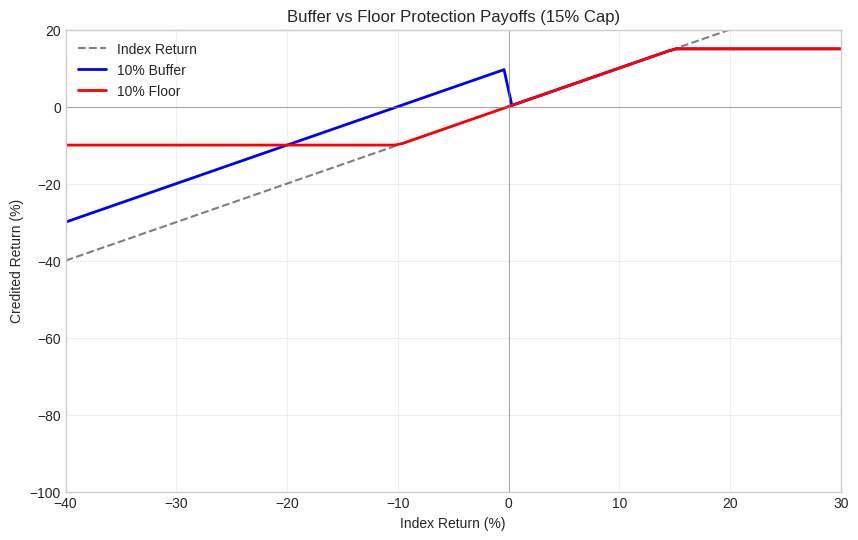

In [9]:
# Visualize payoff profiles
index_returns = np.linspace(-0.40, 0.30, 100)

def buffer_payoff(returns, buffer_rate, cap_rate):
    """Calculate buffer protection payoff."""
    payoffs = np.where(
        returns >= 0,
        np.minimum(returns, cap_rate),  # Capped on upside
        np.maximum(returns + buffer_rate, 0) + np.minimum(returns + buffer_rate, 0)  # Buffer absorbs first X%
    )
    return np.where(returns < 0, np.maximum(returns + buffer_rate, -(1 - buffer_rate)), payoffs)

def floor_payoff(returns, floor_rate, cap_rate):
    """Calculate floor protection payoff."""
    payoffs = np.where(
        returns >= 0,
        np.minimum(returns, cap_rate),  # Capped on upside
        np.maximum(returns, -floor_rate)  # Floor limits loss
    )
    return payoffs

buffer_payoffs = buffer_payoff(index_returns, 0.10, 0.15)
floor_payoffs = floor_payoff(index_returns, 0.10, 0.15)

plt.figure(figsize=(10, 6))
plt.plot(index_returns * 100, index_returns * 100, 'k--', alpha=0.5, label='Index Return')
plt.plot(index_returns * 100, buffer_payoffs * 100, 'b-', linewidth=2, label='10% Buffer')
plt.plot(index_returns * 100, floor_payoffs * 100, 'r-', linewidth=2, label='10% Floor')
plt.axhline(y=0, color='gray', linewidth=0.5)
plt.axvline(x=0, color='gray', linewidth=0.5)
plt.xlabel('Index Return (%)')
plt.ylabel('Credited Return (%)')
plt.title('Buffer vs Floor Protection Payoffs (15% Cap)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-40, 30)
plt.ylim(-100, 20)
plt.show()

## 4. Unified Registry

### 4.1 Price Multiple Product Types

In [10]:
# Create products of each type
myga = MYGAProduct(
    company_name="Example Life",
    product_name="5-Year MYGA",
    product_group="MYGA",
    status="current",
    fixed_rate=0.045,
    guarantee_duration=5,
)

fia = FIAProduct(
    company_name="Example Life",
    product_name="S&P 500 10% Cap",
    product_group="FIA",
    status="current",
    cap_rate=0.10,
)

rila = RILAProduct(
    company_name="Example Life",
    product_name="10% Buffer S&P",
    product_group="RILA",
    status="current",
    buffer_rate=0.10,
    buffer_modifier="Losses Covered Up To",
    cap_rate=0.15,
)

# Price all through unified registry
products = [myga, fia, rila]
results = registry.price_multiple(products, term_years=1.0, principal=100.0)

print("\nUnified Pricing Results:")
display(results[['company_name', 'product_name', 'product_group', 'present_value', 'duration']])


Unified Pricing Results:


,company_name,product_name,product_group,present_value,duration
0,Example Life,5-Year MYGA,MYGA,97.6416,5.0
1,Example Life,S&P 500 10% Cap,FIA,99.1561,1.0
2,Example Life,10% Buffer S&P,RILA,97.8299,1.0


## 5. Validation Gates

Validate pricing results with HALT/PASS gates:

In [11]:
# Validate FIA result
fia_result = registry.price(fia, term_years=1.0, premium=100.0)
report = validate_pricing_result(fia_result, premium=100.0, cap_rate=0.10)

print(f"Validation Status: {report.overall_status.value.upper()}")
print(f"Passed: {report.passed}")
print(f"\nGate Results:")
for gate in report.results:
    status_icon = '✓' if gate.passed else '✗'
    print(f"  {status_icon} {gate.gate_name}: {gate.message}")

Validation Status: PASS
Passed: True

Gate Results:
  ✓ present_value_bounds: PV 99.1561 within bounds
  ✓ duration_bounds: Duration 1.0000 within bounds
  ✓ fia_option_budget: Option value within budget (ratio: 1.35)
  ✓ fia_expected_credit: Expected credit 0.0424 within bounds
  ✓ rila_max_loss: Not a RILA result, skipping
  ✓ rila_protection_value: Not a RILA result, skipping
  ✓ arbitrage_bounds: No arbitrage violations detected


In [12]:
# Validate RILA result
rila_result = registry.price(rila, term_years=1.0, premium=100.0)
report = validate_pricing_result(rila_result, premium=100.0, buffer_rate=0.10)

print(f"Validation Status: {report.overall_status.value.upper()}")
print(f"\nGate Results:")
for gate in report.results:
    status_icon = '✓' if gate.passed else '✗'
    print(f"  {status_icon} {gate.gate_name}: {gate.message}")

Validation Status: PASS

Gate Results:
  ✓ present_value_bounds: PV 97.8299 within bounds
  ✓ duration_bounds: Duration 1.0000 within bounds
  ✓ fia_option_budget: Not a FIA result, skipping
  ✓ fia_expected_credit: Not a FIA result, skipping
  ✓ rila_max_loss: Max loss 0.9000 is valid
  ✓ rila_protection_value: Protection value 3.6156 is valid
  ✓ arbitrage_bounds: No arbitrage violations detected


## 6. Summary

This notebook demonstrated:

1. **FIA Pricing**: Cap/participation methods, fair term calculation, expected credit
2. **RILA Pricing**: Buffer vs floor protection, payoff visualization, max loss
3. **Unified Registry**: Single interface for all product types
4. **Validation Gates**: HALT/PASS framework for pricing validation

### Key Insights

| Product | Protection | Upside | Key Trade-off |
|---------|-----------|--------|---------------|
| MYGA | 100% principal | Fixed rate | Lower return, certainty |
| FIA | 0% floor | Capped index | Higher return, capped upside |
| RILA Buffer | First X% losses | Capped index | Moderate risk, moderate return |
| RILA Floor | Max loss = X% | Capped index | Tail protection, similar expected return |